## Statistics of Tropical Cyclones (TCs) wind fields derived from Synthetic Aperture Radar (SAR) imagery
Dataset of 341 SAR files stored in .zarr format

TODO:
- Compute correlation instead of covariance;


In [1]:
# General
import glob
import os.path
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from matplotlib.colors import Normalize
# from matplotlib.colors import ListedColormap
# import matplotlib.cm as cm
import pandas as pd

# Data treatment
import dask as da
from dask.diagnostics import ProgressBar
import zarr
from scipy.interpolate import griddata
from datetime import datetime

# Custom
import dataUtils as du

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
### PARAMS
PARAMS = {'save_figs': False    
         }

### PATHS
dir_path = '/home/arthur/data/cyclobs/centered_rotated_files_06012022/clean_dataset/zarr_data/'
save_dir = '/home/arthur/results/bigData2022_covariance/v2/'
filename = 'tc_sar_data.zarr'

### OPEN FILES
ds_all = xr.open_zarr(dir_path + filename)
ds_all

<xarray.Dataset>
Dimensions:                                        (time: 341, x: 1000, y: 1000)
Coordinates:
  * time                                           (time) datetime64[ns] 2012...
  * x                                              (x) int64 -499000 ... 500000
  * y                                              (y) int64 -499000 ... 500000
Data variables: (12/35)
    across_wind_from_direction_component           (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    across_wind_parametrized                       (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    across_wind_streaks_orientation_component      (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    along_wind_from_direction_component            (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    along_wind_parametrized                        (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    along_wind_streaks_orientation_component       (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    ...                                             ...
    tangential_wind_streaks_orientation_component  (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    wind_from_direction                            (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    wind_speed                                     (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    wind_streaks_orientation                       (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    wind_streaks_orientation_stddev                (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    zonal_interp_parametrized                      (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>

In [3]:
### PLOTTING WIND FIELDS 
# Print the first TC of the Dataset
### OUTLIERS: i= 3, 4, 5
# du.plot_wind_field(ds_all, time_idx=5)

# Print all the TCs named 'HECTOR'
# storm_name = 'HECTOR'
# print('Indexes for %s: '%storm_name, find_time_idx(ds_all, storm_name))
# for time_idx in find_time_idx(ds_all, storm_name):
#     plot_wind_field(ds_all, time_idx)

In [21]:
th_ref_ax

array([  0.        ,  51.28571429, 102.57142857, 153.85714286,
       205.14285714, 256.42857143, 307.71428571, 359.        ])

In [4]:
### CONVERT TO POLAR R* GRID AND CONCATENATE
listOfDatasets  = []
r_ref_ax        = du.create_reference_axis(size=8, interval=0.5)
th_ref_ax       = du.create_reference_axis(size=360, interval=45.)
crop_thresh     = 300000

n_total = len(ds_all['time'])
n_test  = 5
n       = n_total
ds_all  = ds_all.isel(time=slice(0, n))

### PREPARATION OF THE DATASET
# Filter
ds_all = du.filter_out_whole_dataset(ds_all)
# Crop
# ds_all = ds_all.sel(x=slice(-crop_thresh, crop_thresh), y=slice(-crop_thresh, crop_thresh))
# Eventually save 
# du.save_all_wind_fields(ds_all, save_dir='/home/arthur/results/bigData2022_covariance/341_files_rotated_cartesian_filtered/')

### CONVERT TO POLAR
print('Converting to polar coordinates...')
for time_idx in tqdm(range(n)):
    ds_polar  = du.get_ds_in_polar_r_star_coords_v03(ds_all, time_idx, r_ref_ax, th_ref_ax)
    listOfDatasets.append(ds_polar)
ds_polar_all            = xr.concat(listOfDatasets, dim='time')

Filtering wind speed pixel outliers...


100%|█████████████████████████████████████████| 341/341 [01:13<00:00,  4.65it/s]


Converting to polar coordinates...


100%|█████████████████████████████████████████| 341/341 [03:34<00:00,  1.59it/s]


In [5]:
for cat, ds_cat in ds_polar_all.groupby('cat'):   
    ### MEAN
    ax    = plt.subplot(projection = "polar")
    plt.title('Cat. %i'%cat + '\n%i TCs'%ds_cat.dims['time'], weight='bold')
    mean  = ds_cat.mean('time', skipna=True)['wind_speed']
    r, th = np.meshgrid(mean['r*'], mean['th'])
    plt.pcolormesh(np.deg2rad(th), r, mean);plt.colorbar();plt.grid() # Put theta in radians!! 
    ax.set_theta_zero_location("N")  # theta=0 at the top
    ax.set_theta_direction(-1)  # theta increasing clockwise
    plt.savefig(save_dir + 'mean_cat%i'%cat) if PARAMS['save_figs'] else plt.show()
    plt.clf()
    
    ### STD    
    ax    = plt.subplot(projection = "polar")
    std   = ds_cat.std('time', skipna=True)['wind_speed']
    r, th = np.meshgrid(std['r*'], std['th'])
    plt.pcolormesh(np.deg2rad(th), r, std);plt.colorbar();plt.grid() # Put theta in radians!! 
    ax.set_theta_zero_location("N")  # theta=0 at the top
    ax.set_theta_direction(-1)  # theta increasing clockwise
    plt.savefig(save_dir + 'std_cat%i'%cat) if PARAMS['save_figs'] else plt.show()
    plt.clf()

<Figure size 1080x720 with 0 Axes>

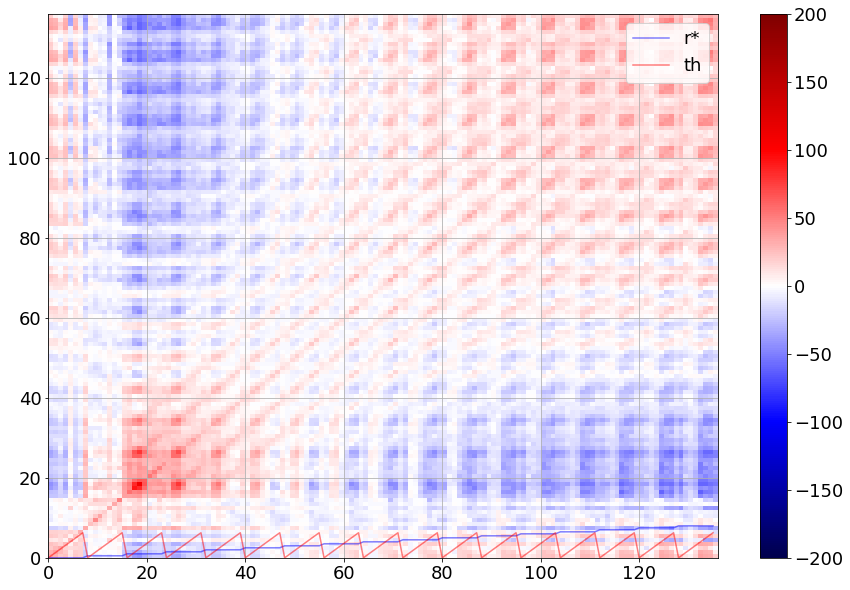

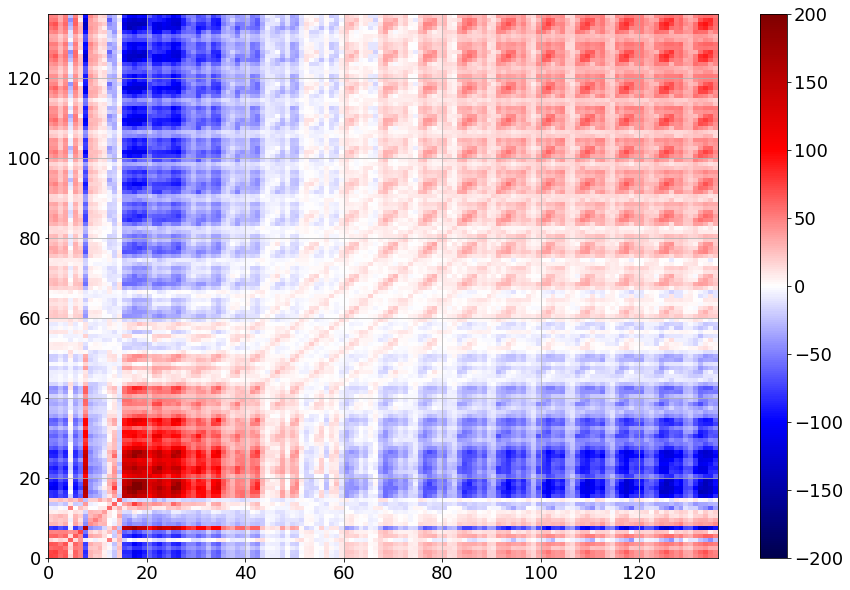

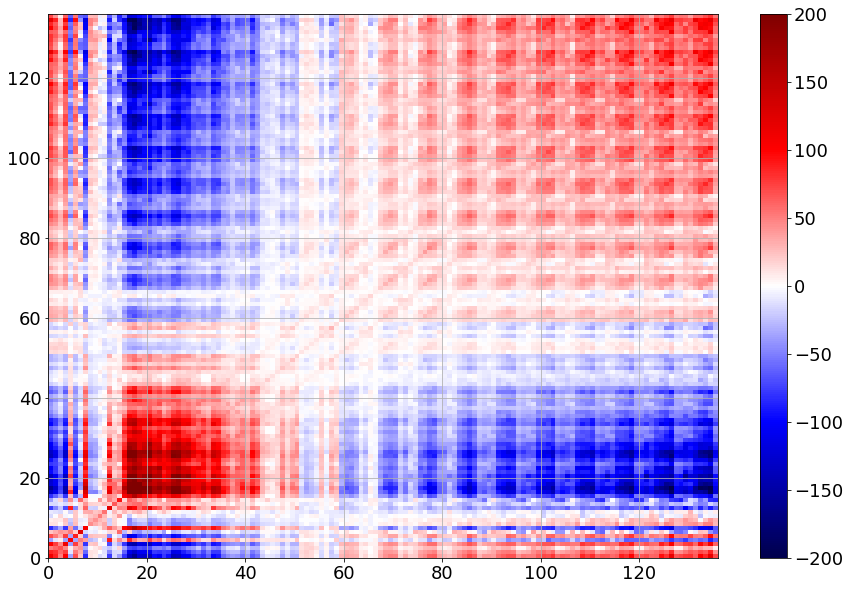

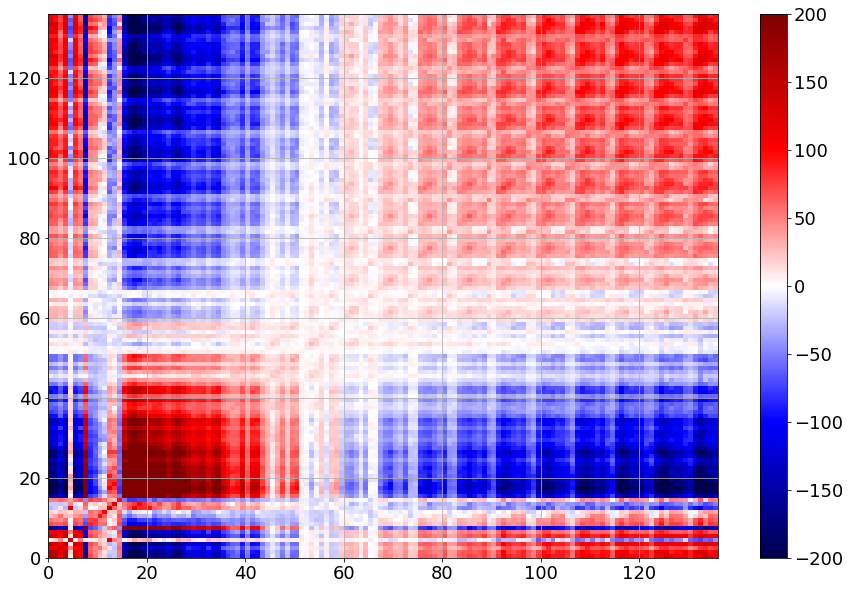

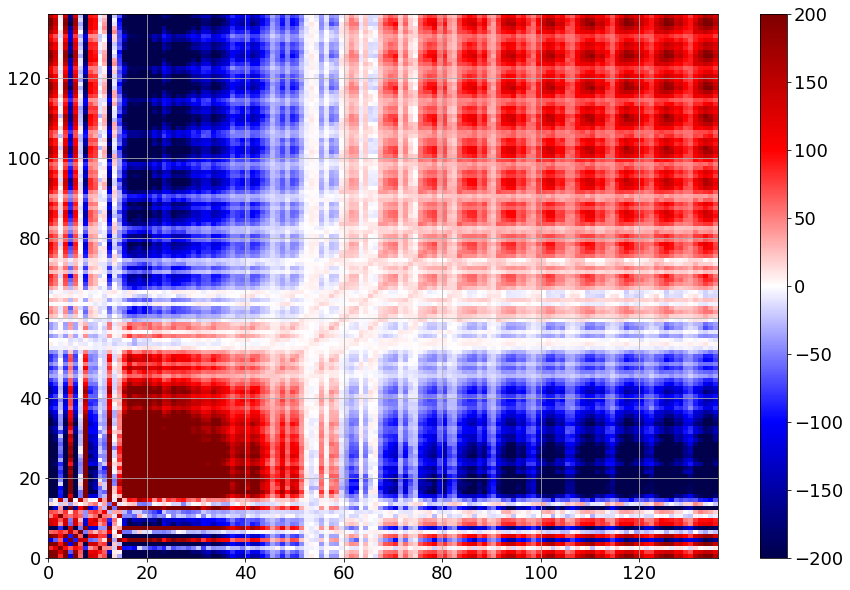

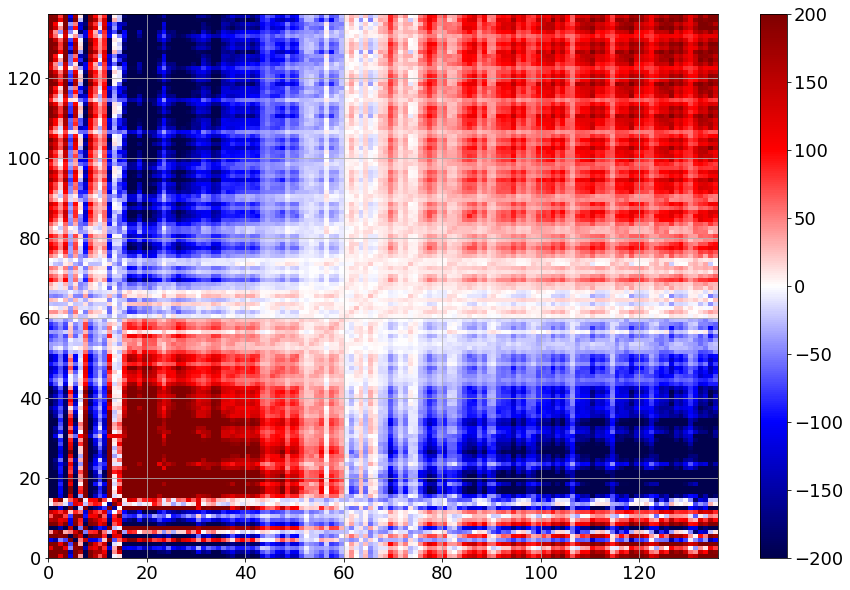

In [6]:
### COVARIANCE MATRIX IN POLAR COORDINATES BY CATEGORY

# TODO: divide covariance by norm of x_Ex to display correlation

COV_MAT_CAT = [None for i in range(6)]
for cat, ds_cat in ds_polar_all.groupby('cat'):
    COV_MAT_CAT[cat], ds_polar_stack = du.covariance_matrix(ds_cat, order_by='r*')
    
    if cat == 0:
        ### SHOW HOW PIXELS EVOLVE
        if not PARAMS['save_figs']: fig = plt.subplots(figsize=(12.3, 5))
        plt.plot(np.array(ds_polar_stack['r*']).flatten(), c='b', label='r*', alpha=0.5)
        plt.plot(np.array(np.deg2rad(ds_polar_stack['th'])).flatten(), c='r', label='th', alpha=0.5)
        plt.legend();plt.grid()
        plt.savefig(save_dir + 'r_star_scale') if PARAMS['save_figs'] else plt.show()
    
    plt.clf()
    plt.pcolormesh(COV_MAT_CAT[cat], cmap='seismic', vmin=-200, vmax=200);plt.colorbar();plt.grid()
    if PARAMS['save_figs']: plt.savefig(save_dir + 'cov_mat_cat%i_orderBy_r'%cat)
    plt.show()

Cat. 0 = 92


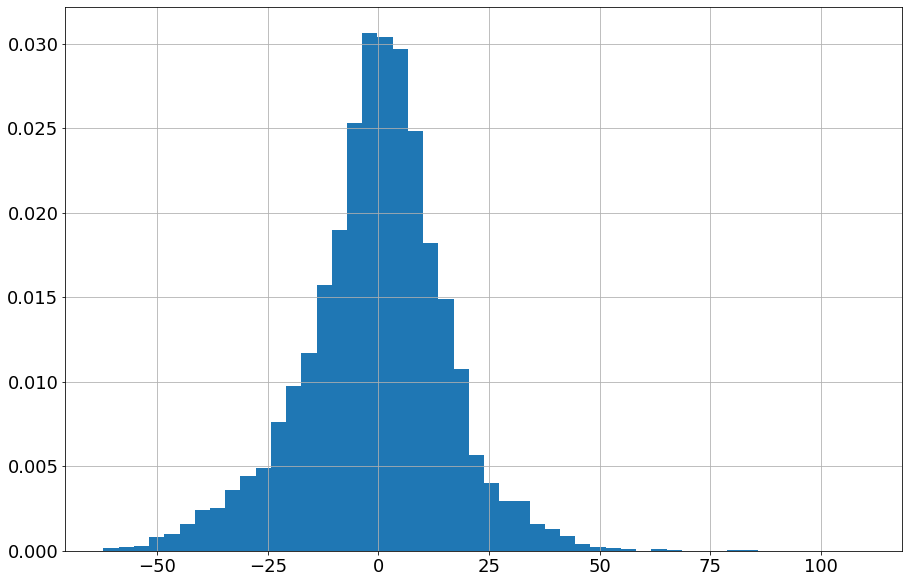

Cat. 1 = 82


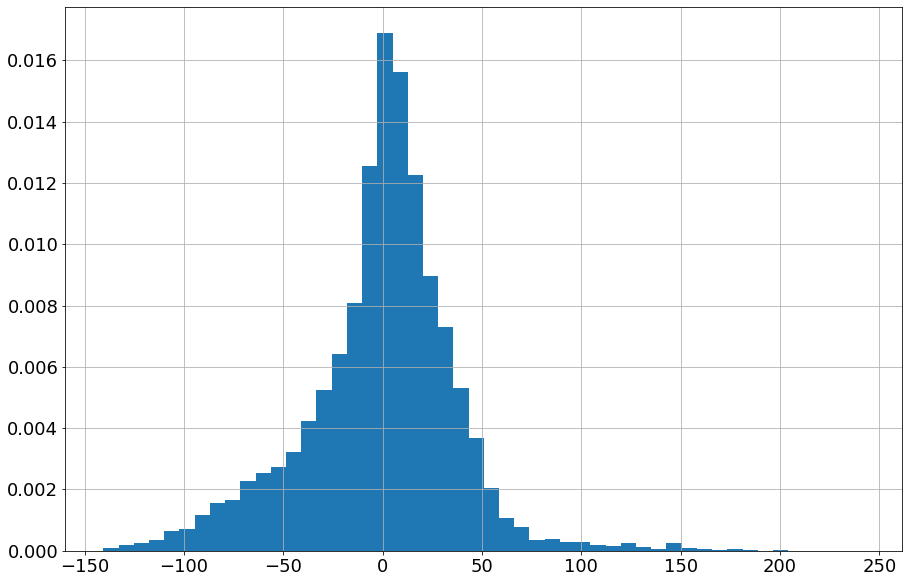

Cat. 2 = 41


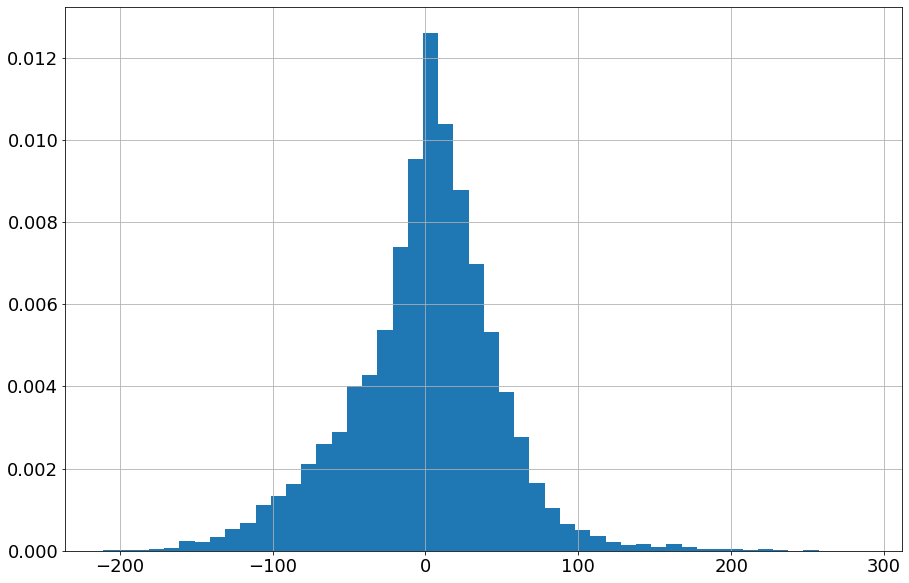

Cat. 3 = 55


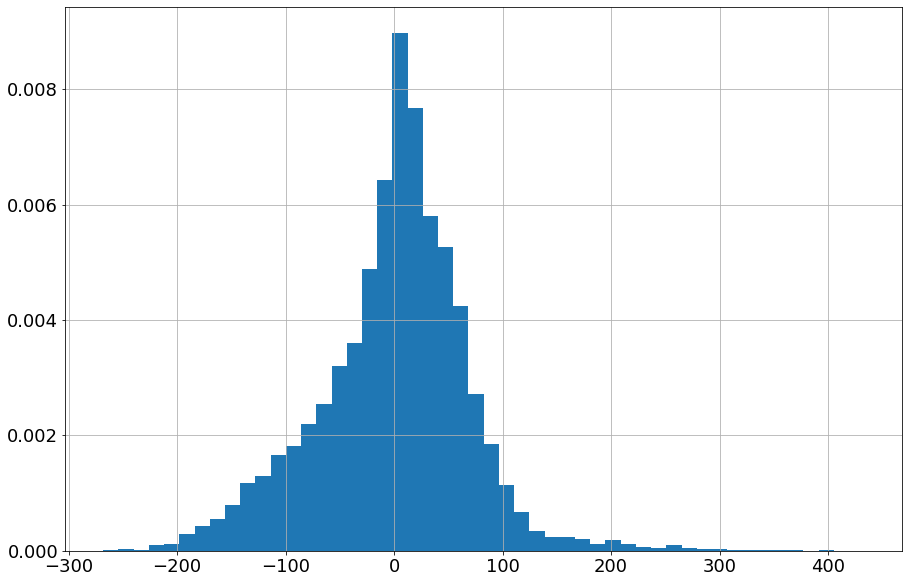

Cat. 4 = 54


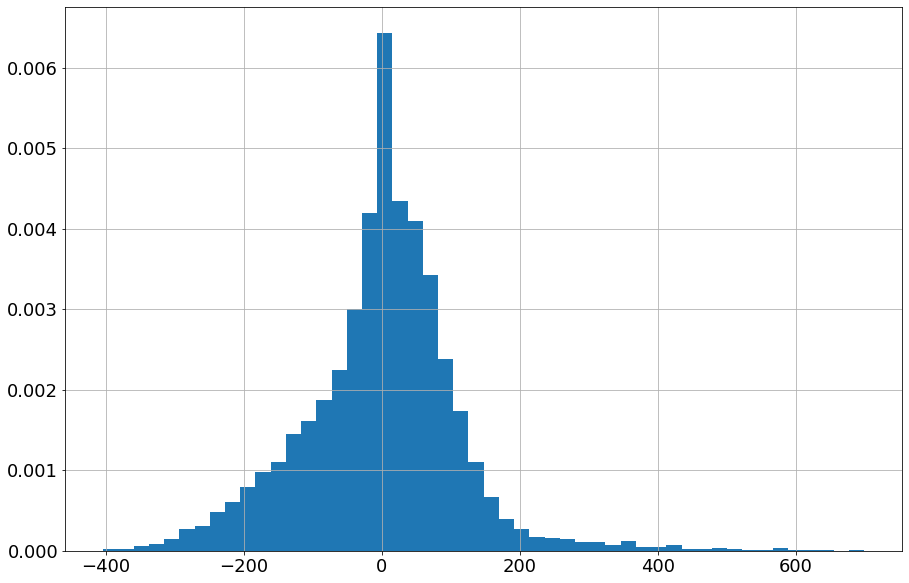

Cat. 5 = 17


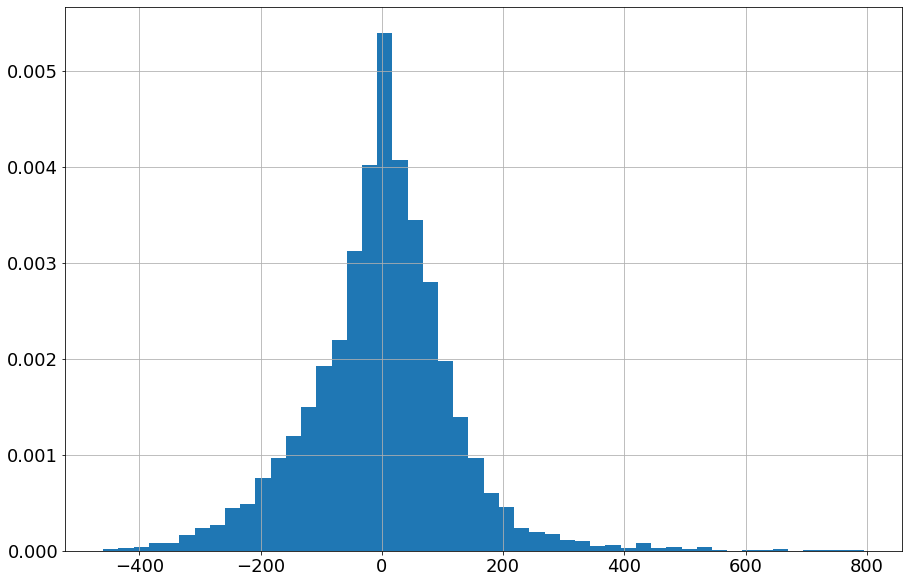

In [7]:
### HISTOGRAMS
for cat, ds_cat in ds_polar_all.groupby('cat'):
    print('Cat. %i ='%cat, ds_cat.dims['time'])
    plt.hist(COV_MAT_CAT[cat].flatten(), bins=50, density=True);plt.grid()
    plt.show()

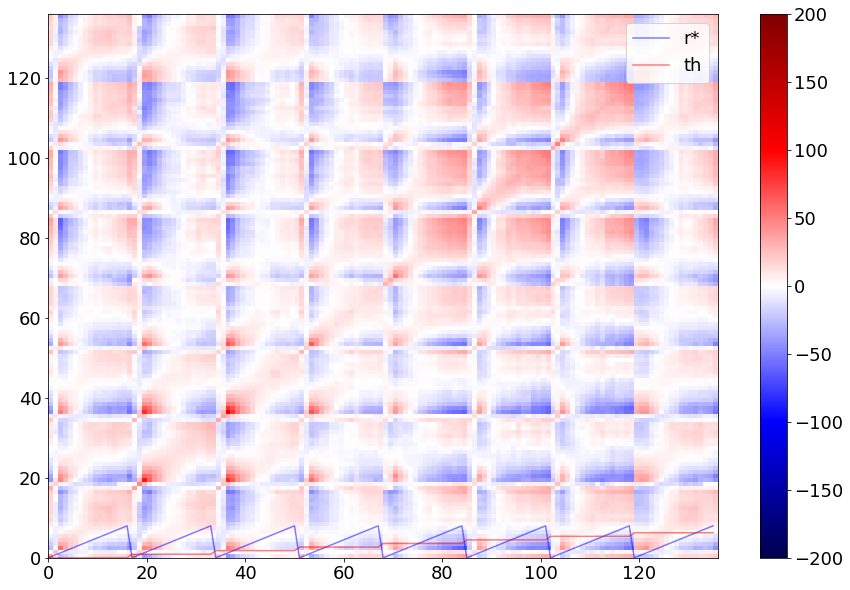

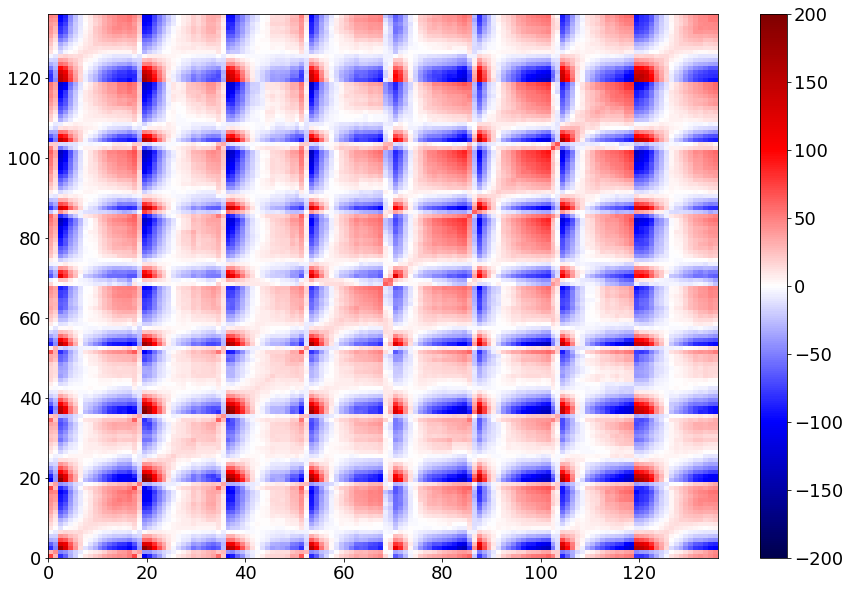

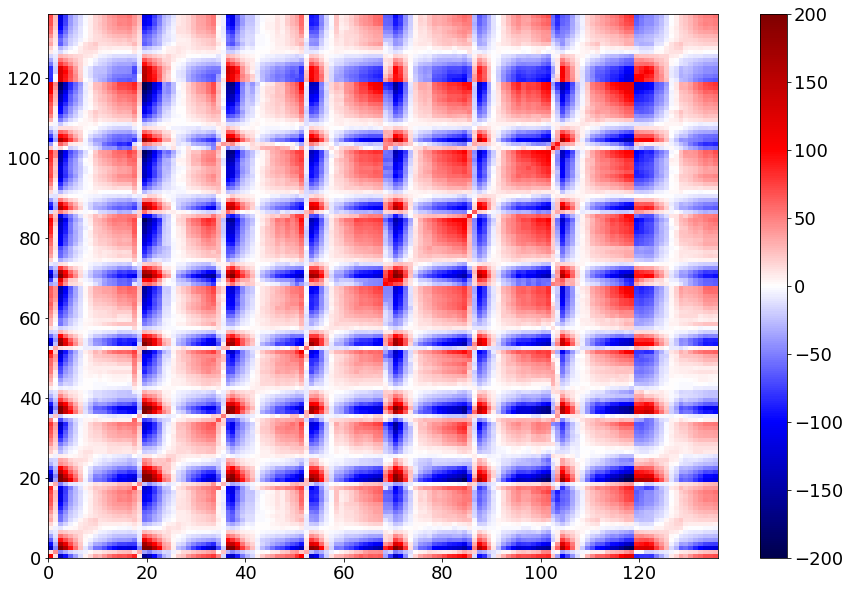

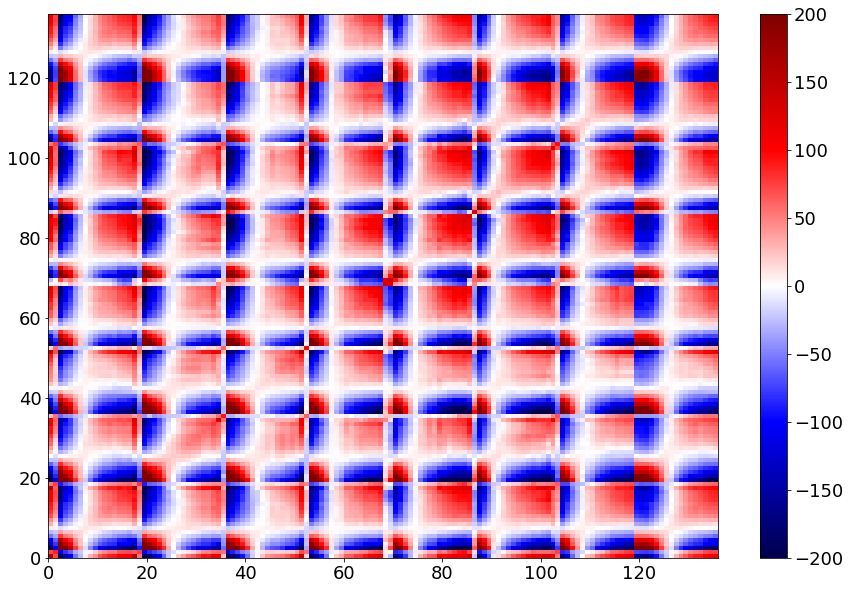

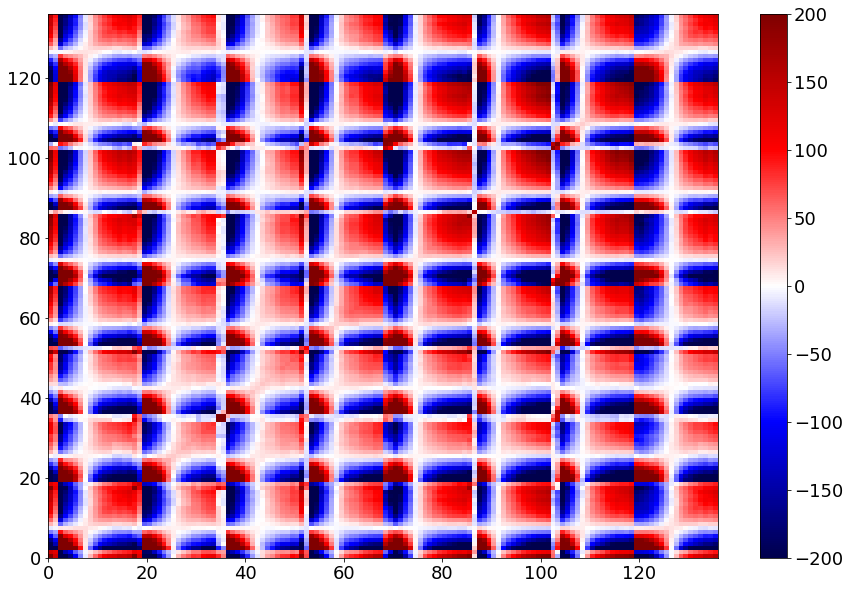

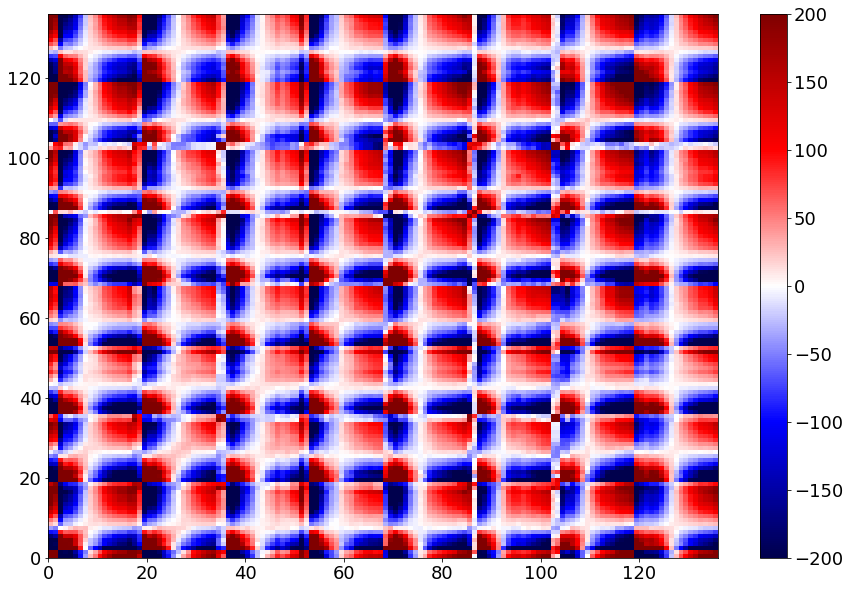

In [8]:
### ORDER BY THETA
COV_MAT_CAT = [None for i in range(6)]
for cat, ds_cat in ds_polar_all.groupby('cat'):
    COV_MAT_CAT[cat], ds_polar_stack = du.covariance_matrix(ds_cat, order_by='th')
    
    if cat == 0:
        ### SHOW HOW PIXELS EVOLVE
        if not PARAMS['save_figs']: fig = plt.subplots(figsize=(12.3, 5))
        plt.plot(np.array(ds_polar_stack['r*']).flatten(), c='b', label='r*', alpha=0.5)
        plt.plot(np.array(np.deg2rad(ds_polar_stack['th'])).flatten(), c='r', label='th', alpha=0.5)
        plt.legend();plt.grid()
        plt.savefig(save_dir + 'th_scale') if PARAMS['save_figs'] else plt.show()
    
    plt.clf()
    plt.pcolormesh(COV_MAT_CAT[cat], cmap='seismic', vmin=-200, vmax=200);plt.colorbar()
    if PARAMS['save_figs']: plt.savefig(save_dir + 'cov_mat_cat%i_orderBy_th'%cat)
    plt.show()

In [9]:
### OLD LINES
# plt.hist(COV_MAT_CAT[0].flatten(), bins=50, density=True);plt.grid()
# plt.pcolormesh(ds_polar_all.mean(dim='time', skipna=True)['wind_speed']);plt.colorbar()
# plt.pcolormesh(ds_polar_all.isel(time=1)['wind_speed']);plt.colorbar();plt.grid()

In [10]:
### OLD VERSION FOR INTERPOLATING ON (R*, TH) GRID

# import importlib
# importlib.reload(du)

# # Create reference polar axis
# r_star_ref_ax = du.create_reference_axis(size=4, interval=0.005)
# theta_ref_ax  = du.create_reference_axis(size=360, interval=0.5)

# # Convert ds to polar coordinates
# ds_polar = du.get_ds_in_polar_r_star_coords(r_star_ref_ax, theta_ref_ax, ds_all, time_idx=2)
# ds_polar

# # Plot polar
# # ds    = ds_polar.isel(time=0)
# # plt.subplot(projection = "polar")
# # r, th = np.meshgrid(ds['r*'], ds['th'], indexing='ij') # keep (r, th) order
# # plt.pcolormesh(th, r, ds['wind_speed']);plt.colorbar()

# # Cartesian plot
# ds   = ds_polar.isel(time=0)
# print(ds['wind_speed'].shape)
# r, th = np.meshgrid(ds['r*'], ds['th'], indexing='ij') # keep (r, th) order
# th   = np.deg2rad(th)
# x, y = du.pol2cart(r, th)
# plt.pcolormesh(x, y, ds['wind_speed']);plt.colorbar();plt.grid()

In [11]:
# # Parameters
# n_total = len(ds_all['time'])
# n       = 50 # nb of samlpes

# # Put on lower resolution grid
# resolution = 25 # in pixels (here = km)
# xHR, yHR   = np.meshgrid(ds_all['x'], ds_all['y'])
# xLR, yLR   = np.meshgrid(ds_all['x'][::resolution], ds_all['y'][::resolution])

# # Concatenate samples only with Rmax < 150
# ds           = ds_all.isel(time=0)
# r, th        = cart2pol(ds['x'], ds['y'])
# ds           = ds.assign_coords({'r': r, 'th': th})
# ds_wsHR      = np.array(ds['wind_speed'])             # convert to np.array
# conc         = griddata((xHR.flatten(), yHR.flatten()), ds_wsHR.flatten(), (xLR, yLR), method='nearest')
# conc         = np.expand_dims(conc, axis=0)
# Rmax_conc, _ = compute_SAR_2D_Rmax_Vmax(ds)
# Rmax_conc    = np.expand_dims(Rmax_conc, axis=0)
# for i in tqdm(range(n - 1)):
#     i += 1
#     ds    = ds_all.isel(time=i)
    
#     # Assign polar coordinates to ds
#     r, th = cart2pol(ds['x'], ds['y'])
#     ds    = ds.assign_coords({'r': r, 'th': th})
    
#     # LR
#     ds_wsHR      = np.array(ds['wind_speed'])             # convert to np.array
#     new          = griddata((xHR.flatten(), yHR.flatten()), ds_wsHR.flatten(), (xLR, yLR), method='nearest')
#     new          = np.expand_dims(new, axis=0)
#     # plot_wind_field(ds_all, i)
    
#     # Compute Rmax and concatenate
#     Rmax_new, _ = compute_SAR_2D_Rmax_Vmax(ds)
#     Rmax_new    = np.expand_dims(Rmax_new, axis=0)
#     if np.round(Rmax_new / 1000) < 150:
#         conc      = np.concatenate((conc, new), axis=0)
#         Rmax_conc = np.concatenate((Rmax_conc, Rmax_new), axis=0)
#     else:
#         print('Sample n°%i not added: Rmax = '%i, np.round(Rmax_new / 1000))
        
# Rmax_conc /= 1000. # convert to km

In [12]:
# ### COVARIANCE OF FIRST n FIELDS
# n_total = len(ds_all['time'])
# n       = 50 # nb of samlpes
# dsn     = ds_all.isel(time=slice(0, n))

# # Put on lower resolution grid
# resolution = 25 # in pixels (here = km)
# xHR, yHR   = np.meshgrid(dsn['x'], dsn['y'])
# xLR, yLR   = np.meshgrid(dsn['x'][::resolution], dsn['y'][::resolution])

# # Interpolate to lower resolution and concatenate
# # Initialize
# ds_wsHR    = np.array(dsn.isel(time=0)['wind_speed']) # convert to np.array
# conc       = griddata((xHR.flatten(), yHR.flatten()), ds_wsHR.flatten(), (xLR, yLR), method='nearest')
# conc       = np.expand_dims(conc, axis=0)
# # Loop
# for i in tqdm(range(n - 1)):
#     i         += 1
#     ds_wsHR    = np.array(dsn.isel(time=i)['wind_speed']) # convert to np.array
#     new        = griddata((xHR.flatten(), yHR.flatten()), ds_wsHR.flatten(), (xLR, yLR), method='nearest')
#     new        = np.expand_dims(new, axis=0)
#     conc       = np.concatenate((conc, new), axis=0)   
# print('Shape of concatenated array: ', conc.shape)

# # Flatten
# flat = np.reshape(conc, (conc.shape[0], conc.shape[1] * conc.shape[2]))
# print('Shape of flattened array: ', flat.shape)

In [13]:
# # Compute covariance USING DASK
# # CAVEAT: how NaNs are handled? 
# z       = da.array.cov(flat, rowvar=False)
# cov_mat = z.compute()
# plt.pcolormesh(cov_mat);plt.colorbar()

In [14]:
# # Compute covariance handling NaNs
# gap     = flat - np.nanmean(flat, axis=0) # 10 samples of x - E(x) transposed
# print('Shape of gap:', gap.shape)

# # Initialize
# x_Ex    = np.expand_dims(gap[0, :], axis=1)
# product = np.dot(x_Ex, np.transpose(x_Ex))
# product = np.expand_dims(product, axis=0)
# # Loop
# for i in tqdm(range(n - 1)):
#     x_Ex    = np.expand_dims(gap[i, :], axis=1)
#     new     = np.dot(x_Ex, np.transpose(x_Ex))
#     new     = np.expand_dims(new, axis=0)
#     product = np.concatenate((product, new), axis=0)
# print('Shape of product: ', product.shape)

# # Compute average
# # i.e E(product) where product = (x - E(x)).(x - E(x)).T
# cov_mat = np.nanmean(product, axis=0)
# print('Shape of covariance matrix: ', cov_mat.shape)

# # Plot
# cov_mat.shape
# plt.pcolormesh(cov_mat, cmap='coolwarm');plt.colorbar();plt.grid()

In [15]:
# ### Compute covariance matrix of TCs with Rmax
# # Flatten
# flat = np.reshape(conc, (conc.shape[0], conc.shape[1] * conc.shape[2]))
# print('Shape of flattened array: ', flat.shape)

# # Compute covariance handling NaNs
# gap_ws   = flat - np.nanmean(flat, axis=0)   # 10 samples of x - E(x) transposed
# gap_rmax = Rmax_conc - np.nanmean(Rmax_conc) # same for Rmax
# print('Shape of gap:', gap_ws.shape)

# # Initialize
# product = gap_ws[0, :] * gap_rmax[0]
# product = np.expand_dims(product, axis=0)
# # Loop
# for i in tqdm(range(gap_ws.shape[0] - 1)):
#     i      += 1
#     new     = gap_ws[i, :] * gap_rmax[i]
#     new     = np.expand_dims(new, axis=0)
#     product = np.concatenate((product, new), axis=0)
# print('Shape of product: ', product.shape)

# # Compute average
# # i.e E(product) where product = (x - E(x)).(x - E(x)).T
# cov_mat = np.nanmean(product, axis=0)
# print('Shape of covariance matrix: ', cov_mat.shape)

# # Plot
# cov_mat = np.reshape(cov_mat, (40, 40))
# plt.pcolormesh(cov_mat);plt.colorbar();plt.grid()

#### Covariance between TC and Vmax_2D

In [16]:
# from scipy.signal import convolve2d

# def cart2pol(x, y):
#     r  = np.sqrt(x**2 + y**2)
#     th = np.arctan2(y, x)
#     return r, th

# def compute_SAR_2D_Rmax_Vmax(ds):
#     # Put zeros where NaNs and ones elsewhere
#     ds_ws                    = np.asarray(ds['wind_speed'])
#     ds_ones                  = np.ones(ds_ws.shape)
#     ds_ones[np.isnan(ds_ws)] = 0.

#     # Convolve this with a 10 x 10 kernel of ones to count the number of NaNs
#     kernel                   = np.ones((10, 10))
#     valid_counter            = convolve2d(ds_ones, kernel, mode='same')
#     valid_counter           /= kernel.shape[0] * kernel.shape[1]

#     # Set to NaN where threshold is exceeded
#     thresh                        = 0.99
#     ds_ws[valid_counter < thresh] = np.nan # if there is less than 99% (thresh = 0.99) of valid values, we set to nan 

#     # Compute Rmax_SAR_2D and Vmax_SAR_2D
#     idx_max                  = np.nanargmax(ds_ws)
#     Vmax_SAR_2D              = np.reshape(np.asarray(ds_ws), -1)[idx_max]
#     Rmax_SAR_2D              = np.reshape(np.asarray(ds['r']), -1)[idx_max]
    
#     return Rmax_SAR_2D, Vmax_SAR_2D

# # Concatenate samples only with Rmax < 150
# n            = n_total
# ds           = ds_all.isel(time=0)
# r, th        = cart2pol(ds['x'], ds['y'])
# ds           = ds.assign_coords({'r': r, 'th': th})
# conc         = np.array(ds['wind_speed'])             # convert to np.array
# conc         = np.expand_dims(conc, axis=0)
# _, Vmax_conc = compute_SAR_2D_Rmax_Vmax(ds)
# Vmax_conc    = np.expand_dims(Vmax_conc, axis=0)
# for i in tqdm(range(n - 1)):
#     i += 1
#     ds    = ds_all.isel(time=i)
    
#     # Assign polar coordinates to ds
#     r, th = cart2pol(ds['x'], ds['y'])
#     ds    = ds.assign_coords({'r': r, 'th': th})
    
#     new          = np.array(ds['wind_speed'])             # convert to np.array
#     new          = np.expand_dims(new, axis=0)
    
#     # Compute Rmax/Vmax and concatenate
#     Rmax_new, Vmax_new = compute_SAR_2D_Rmax_Vmax(ds)
#     Vmax_new           = np.expand_dims(Vmax_new, axis=0)
#     if round(Rmax_new / 1000) < 150:
#         conc      = np.concatenate((conc, new), axis=0)
#         Vmax_conc = np.concatenate((Vmax_conc, Vmax_new), axis=0)
#     else:
#         print('Sample n°%i not added: Rmax = '%i, round(Rmax_new / 1000))

In [17]:
# ### Compute covariance matrix of TCs with Vmax_2D
# # Flatten
# flat = np.reshape(conc, (conc.shape[0], conc.shape[1] * conc.shape[2]))
# print('Shape of flattened array: ', flat.shape)

# # Compute covariance handling NaNs
# gap_ws   = flat - np.nanmean(flat, axis=0)   # 10 samples of x - E(x) transposed
# gap_vmax = Vmax_conc - np.nanmean(Vmax_conc) # same for Vmax

# # Initialize
# product = gap_ws[0, :] * gap_vmax[0]
# product = np.expand_dims(product, axis=0)
# # Loop
# for i in tqdm(range(len(gap_vmax) - 1)):
#     i      += 1
#     new     = gap_ws[i, :] * gap_vmax[i]
#     new     = np.expand_dims(new, axis=0)
#     product = np.concatenate((product, new), axis=0)
# print('Shape of product: ', product.shape)

# # Compute average
# # i.e E(product) where product = (x - E(x)).(x - E(x)).T
# cov_mat = np.nanmean(product, axis=0)
# print('Shape of covariance matrix: ', cov_mat.shape)

# # Plot
# cov_mat = np.reshape(cov_mat, (1000, 1000))
# plt.pcolormesh(cov_mat);plt.colorbar();plt.grid()

In [18]:
### DISPLAY ALL SOUTHERN HEMISPHERE TCs
# ds2 = ds_all.where(ds_all['lat'][:, 499, 499] < 0)
# ds2['wind_speed'][:, :, :].values
# for time_idx in range(len(ds2.time)):
#     if ds_all['lat'][time_idx, 499, 499] < 0:
#         print(time_idx)
#         plot_wind_field(ds_all, time_idx=time_idx)

In [19]:
### TODO: Interpolate on regular (r, th) grid (OPTIONAL)
### Shift SH TCs ==> Already done
### REMOVE outlier pixels 
### Questions: how many cat.0, cat.1 etc.. do we have? In which basins? Wind field max? Wind speed mean? Average wind field etc...? Average wind field per category? 1D profile? 
### Covariance matrix? 1D covariance? 